# 06. Deployment

### Importando as bibliotecas

In [1]:
import sys
from datetime import datetime
sys.path.append('..')
import yfinance as yF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Definindo os parâmetros do modelo

In [2]:
TICKER = 'VALE3.SA'
# TICKER = 'WEGE3.SA'
# TICKER = 'ROXO34.SA'
# TICKER = 'AAPL'

PERIODO = '1y' # Opções: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y e ytd
DIAS_POSTERIORES = 180
SIMULACOES = 2500
DATA = datetime.today().strftime('%Y-%m-%d')

### Realizando as simulações

In [3]:
df = yF.Ticker(TICKER).history(period=PERIODO)

In [4]:
pd.options.display.float_format = '{:.2f}'.format

In [5]:
df = df.drop(['Stock Splits', 'Dividends'], axis=1)

In [6]:
retorno_diario = df['Close'].pct_change().dropna()

df = pd.merge(df, retorno_diario, how='inner', on='Date')

df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily Variation']

In [7]:
log_retorno_diario = (np.log(df['Close']) - np.log(df['Close']).shift(-1)).dropna()
log_media_retorno_diario = np.mean(log_retorno_diario)
log_desvio_retorno_diario = np.std(log_retorno_diario)

ultimo_preco = df['Close'].iloc[-1]

results = np.empty((SIMULACOES, DIAS_POSTERIORES))

for s in range(SIMULACOES):
    
    random_returns = 1 + np.random.normal(
        loc = log_media_retorno_diario, 
        scale = log_desvio_retorno_diario,
        size = DIAS_POSTERIORES
    )

    result = ultimo_preco * (random_returns.cumprod())

    results[s, :] = result

In [8]:
index = pd.date_range(DATA, periods=DIAS_POSTERIORES, freq='D')
resultados = pd.DataFrame(results.T, index=index)
media_resultados = resultados.apply('mean', axis=1)

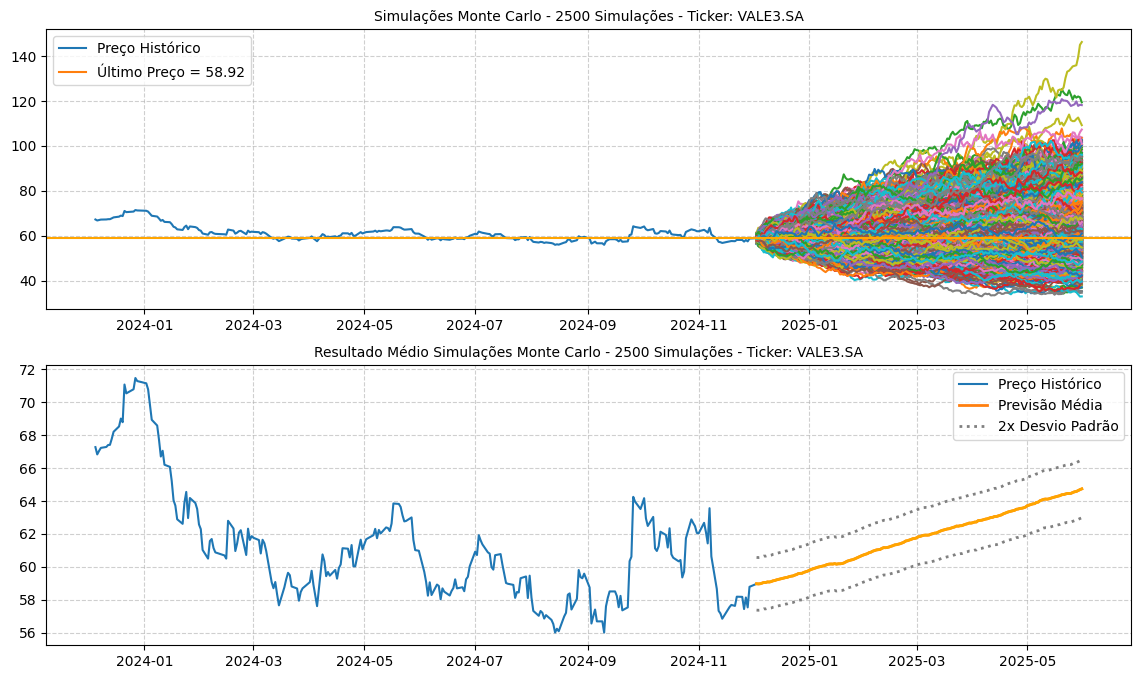

In [9]:
fig, ax = plt.subplots(figsize=(14,8), nrows=2, ncols=1)

ax[0].plot(df['Close'])
ax[0].plot(resultados)
ax[0].axhline(ultimo_preco, c='orange')
ax[0].set_title(f'Simulações Monte Carlo - {SIMULACOES} Simulações - Ticker: {TICKER}', size=10)
ax[0].legend(['Preço Histórico', f'Último Preço = {ultimo_preco:.2f}'])
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].plot(df['Close'])
ax[1].plot(resultados.apply('mean', axis=1), lw=2)
ax[1].plot(media_resultados.apply((lambda x: x * (1+1.96 * log_desvio_retorno_diario))), lw=2, linestyle = 'dotted', c='gray')
ax[1].plot(media_resultados, lw=2, c='orange')
ax[1].plot(media_resultados.apply((lambda x: x * (1-1.96 * log_desvio_retorno_diario))), lw=2, linestyle = 'dotted', c='gray')
ax[1].set_title(f'Resultado Médio Simulações Monte Carlo - {SIMULACOES} Simulações - Ticker: {TICKER}', size=10)
ax[1].legend(['Preço Histórico', 'Previsão Média', '2x Desvio Padrão'])
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.show()